In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
from numpy import log as ln
G = 6.67*(10**(-8))*(1/(3.08*(10**18)))**3
R = np.linspace(10,30*10**3)
R_b = np.linspace(10, 20*10**3)
h = 10 * 10**3

from astropy.table import QTable
from scipy.optimize import curve_fit
import astropy.units as u

DTable = QTable.read('7443-12705_rot_curve_data.txt', format='ascii.ecsv')

In [30]:
DTable

deprojected_distance,max_velocity,max_velocity_error,min_velocity,min_velocity_error,rot_vel_avg,rot_vel_avg_error,sMass_interior,sVel_rot,sVel_rot_error,dmMass_interior,dmMass_interior_error,dmVel_rot,dmVel_rot_error,mass_interior,mass_interior_error,rot_curve_diff,rot_curve_diff_error
kpc,km / s,km / s,km / s,km / s,km / s,km / s,solMass,km / s,km / s,solMass,solMass,km / s,km / s,solMass,solMass,km / s,km / s
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.9370806777150392,48.267180007005955,3.24647352813963,-37.02344508859601,3.34066769419623,42.645312547800984,4.658288420864227,1674184663.8341792,87.65843899875125,0.000985029579867004,-1277944497.2314038,86565246.18807508,nan,nan,396240166.6027754,86565246.18807508,11.243734918409942,4.658288420864227
1.8741613554300784,101.99054088576928,3.01312353739855,-85.77535506085383,3.26780622527759,93.88294797331156,4.444937679831757,6308827511.3750105,120.32375643794009,0.0013520941121683934,-2468048441.9024982,363687431.1085552,nan,nan,3840779069.4725122,363687431.1085552,16.21518582491545,4.444937679831757
2.811242033145118,126.12278052003502,2.89887024162693,-118.78754394497425,3.13925420058445,122.45516223250463,4.2729808815014945,11370181852.430185,131.89099084061473,0.0014820766691707153,-1568708920.143381,684030103.0735639,nan,nan,9801472932.286804,684030103.0735639,7.335236575060776,4.2729808815014945
3.748322710860157,149.94768567069124,2.72861737923452,-155.62138252193418,2.82026089668365,152.7845340963127,3.924184543013176,18763189657.01965,146.72880868793513,0.001648811208905074,1580731959.1622543,1045044393.5735744,42.588385271652086,14.077893796996243,20343921616.181904,1045044393.5735744,5.673696851242937,3.924184543013176
4.685403388575196,166.7740683046965,2.72739194371819,-165.43155678731515,2.78731593276421,166.10281254600582,3.8997175440921494,25799512532.0498,153.8908508686281,0.001729292032894402,4257088803.0495987,1411321905.6499104,62.51200168466225,10.362076248340294,30056601335.0994,1411321905.6499104,1.3425115173813538,3.8997175440921494
5.622484066290236,178.4432552632792,2.6154007924699902,-178.50266605913802,2.70713877361327,178.47296066120862,3.764162807963148,31607211668.267155,155.49252648355252,0.0017472902755744331,10032911059.13277,1756459050.7795386,87.60520472517047,7.668509921791645,41640122727.399925,1756459050.7795386,0.059410795858809706,3.764162807963148
6.559564744005274,187.99904717947894,2.63470402209845,-193.7849322989837,2.6958273124322503,190.89198973923132,3.7695026439196773,38329870264.23938,158.53009050233354,0.0017814237879140908,17246393083.283997,2194905148.553464,106.33890234493083,6.766742667888817,55576263347.52338,2194905148.553464,5.785885119504769,3.7695026439196773
7.496645421720314,196.79311857997328,2.60834930723253,-202.04328216230297,2.74426095222775,199.41820037113814,3.786086935407371,42897538689.209816,156.8784344609789,0.0017628639085107678,26418776293.036476,2632032984.39592,123.11285651927562,6.132704706162263,69316314982.24629,2632032984.39592,5.250163582329691,3.786086935407371


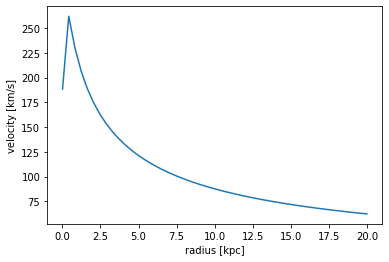

In [2]:
# de Vaucouleurs bulge
sigma_be = 3.2 * (10 ** 3) * 1.988 * (10 ** 33)
r_b = 0.5 * 10 ** 3
gamma = 3.3308
kappa = gamma*ln(10)

def sigma_b(x):
    return sigma_be*np.exp(-1*kappa*((x/r_b)**0.25-1))
                           
# derivative of sigma with respect to r
def dsdx(x):
    return sigma_b(x)*(-0.25*kappa)*(r_b**-0.25)*(x**-0.75)

# integrand for getting denisty
def density_integrand(x,r):
    return -(1/np.pi)*dsdx(x)/np.sqrt(x**2-r**2)

def mass_integrand(r):
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r))
    return 4*np.pi*vol_den*r**2
    
# getting a mass
def velocity(r):
    bulge_mass = np.zeros(len(r))
    vel = np.zeros(len(r))
    for i,val in enumerate(r):
        bulge_mass[i],err = inte.quad(mass_integrand, 0, val)
        vel[i] = np.sqrt(bulge_mass[i]*G/val)
    return vel

'''
def sigma_b(x,a,b):
    return a*np.exp(-1*kappa*((x/b)**0.25-1))
                           
# derivative of sigma with respect to r
def dsdx(x,a,b):
    return sigma_b(x,a,b)*(-0.25*kappa)*(b**-0.25)*(x**-0.75)

# integrand for getting denisty
def density_integrand(x,r,a,b):
    return -(1/np.pi)*dsdx(x,a,b)/np.sqrt(x**2-r**2)

def mass_integrand(r,a,b):
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r,a,b))
    return 4*np.pi*vol_den*r**2
    
# getting velocity
def vel_b(r,a,b):
    bulge_mass = np.zeros(len(r))
    vel = np.zeros(len(r))
    for i,val in enumerate(r):
        bulge_mass[i],err = inte.quad(mass_integrand, 0, val, args=(a,b))
        vel[i] = np.sqrt(bulge_mass[i]*G/val)
    return vel
'''

plt.plot(R_b/1000,velocity(R_b)*(3.08*10**13))
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.show()

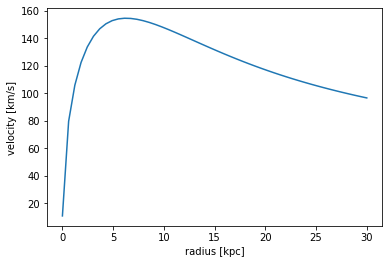

In [3]:
# Exponential Disk
sigma_dc = 8.44 * (10 ** 2) * (1.988*10**33)
r_d = 3.5 * 10**3

def sigma_d(r):
    return sigma_dc*np.exp(-1*(r/r_d))

def integrand_d(r):
    return 2*np.pi*sigma_d(r)*r

def m_d(r):
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_d, 0, val)
        res[i] = y
    return res

def v_d(r):
    return np.sqrt((m_d(r)*G)/r)

'''
def integrand_d(r,c,d):
    2*np.pi*c*np.exp(-1*(r/d))*r

def mass_d(r,c,d):
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_d, 0, val, args=(c,d))
        res[i] = y
    return res

def vel_d(r,c,d):
    return np.sqrt(mass_d(r,c,d)*G/r)
'''

plt.plot(R/1000,v_d(R)*(3.08*10**13))
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.show()

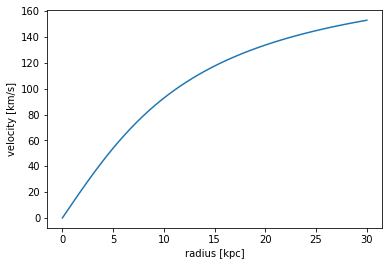

In [4]:
# Isothermal 
rho_0_iso = 0.74 * (h/(10**3))**-2 * (1.988 * 10**33)

def rho_iso(r):
    return rho_0_iso/(1 + (r/h)**2)
def integrand_h_iso(r):
    return 4*np.pi*rho_iso(r)*r**2
def m_h_iso(r):
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h_iso, 0, val)
        res[i] = y
    return res
def v_h_iso(r):
    return np.sqrt((m_h_iso(r)*G)/r)

'''
def rho_iso(r,e,f):
    return e/(1 + (r/f)**2)

def integrand_h(r,e,f):
    e = 0.74 * (f/(10**3))**-2 * (1.988 * 10**33)
    return 4*np.pi*(rho_iso(r,e,f))*r**2

def mass_h(r,e,f):
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h, 0, val, args=(e,f))
        res[i] = y
    return res

def vel_h(r,e,f):
    return np.sqrt(mass_h(r,e,f)*G/r)
'''

plt.plot(R/1000,v_h_iso(R)*(3.08*10**13))
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.show()

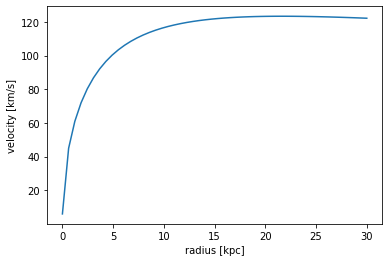

In [5]:
# NFW
rho_0_NFW = 1.3 * (h/(10**3))**-2 * (1.988 * 10**33)

def rho_NFW(r):
    return rho_0_NFW/((r/h)*(1 + (r/h))**2)

def integrand_h_NFW(r):
    return 4*np.pi*rho_NFW(r)*r**2

def m_h_NFW(r):
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h_NFW, 0, val)
        res[i] = y
    return res

def v_h_NFW(r):
    return np.sqrt((m_h_NFW(r)*G)/r)

plt.plot(R/1000,v_h_NFW(R)*(3.08*10**13))
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.show()

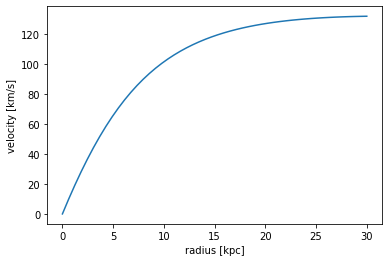

In [6]:
# Burkert 
rho_0_bur = 1.5* (h/(10**3))**-2 * (1.988 * 10**33)

def rho_bur(r):
    return rho_0_bur/((1 + (r/h))*(1 + (r/h)**2))
def integrand_h_bur(r):
    return 4*np.pi*rho_bur(r)*r**2
def m_h_bur(r):
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h_bur, 0, val)
        res[i] = y
    return res
def v_h_bur(r):
    return np.sqrt((m_h_bur(r)*G)/r)

plt.plot(R/1000,v_h_bur(R)*(3.08*10**13))
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.show()

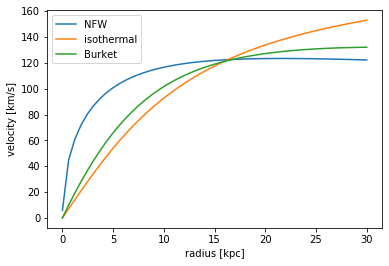

In [7]:
plt.plot(R/1000,v_h_NFW(R)*(3.08*10**13), label='NFW')
plt.plot(R/1000,v_h_iso(R)*(3.08*10**13), label='isothermal')
plt.plot(R/1000,v_h_bur(R)*(3.08*10**13), label='Burket')
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.legend()
plt.show()

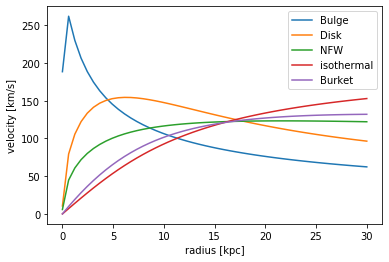

In [8]:
plt.plot(R/1000,velocity(R_b)*(3.08*10**13), label= 'Bulge')
plt.plot(R/1000,v_d(R)*(3.08*10**13), label = 'Disk')
plt.plot(R/1000,v_h_NFW(R)*(3.08*10**13), label='NFW')
plt.plot(R/1000,v_h_iso(R)*(3.08*10**13), label='isothermal')
plt.plot(R/1000,v_h_bur(R)*(3.08*10**13), label='Burket')
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.legend()
plt.show()

In [9]:
vel_t = np.sqrt(velocity(R_b)**2 + v_d(R)**2 + v_h_iso(R)**2)
vel_t_1 = np.sqrt(velocity(R_b)**2 + v_d(R)**2 + v_h_NFW(R)**2)
vel_t_2 = np.sqrt(velocity(R_b)**2 + v_d(R)**2 + v_h_bur(R)**2)

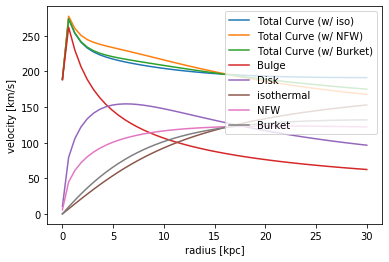

In [10]:
plt.plot(R/1000,vel_t*(3.08*10**13),label = 'Total Curve (w/ iso)')
plt.plot(R/1000,vel_t_1*(3.08*10**13),label = 'Total Curve (w/ NFW)')
plt.plot(R/1000,vel_t_2*(3.08*10**13),label = 'Total Curve (w/ Burket)')
plt.plot(R/1000,velocity(R_b)*(3.08*10**13), label= 'Bulge')
plt.plot(R/1000,v_d(R)*(3.08*10**13), label = 'Disk')
plt.plot(R/1000,v_h_iso(R)*(3.08*10**13), label='isothermal')
plt.plot(R/1000,v_h_NFW(R)*(3.08*10**13), label='NFW')
plt.plot(R/1000,v_h_bur(R)*(3.08*10**13), label='Burket')
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.legend(loc='upper right')
plt.show()

# Try and fit (one halo) given data 
    To read the data (Qtable astropy) in and plot them 
    Use scipy.optimize.curvefit
    Break down the velocities --> solve for different parameters
   


# Testing with Milky Way Parameters

In [11]:
r_dep = DTable['deprojected_distance'].data
max_vel = DTable['max_velocity'].data
min_vel = DTable['min_velocity'].data
ave_vel = DTable['rot_vel_avg'].data

In [12]:
ave_vel_list = []
for i in range(len(ave_vel)):
    ave_vel_list.append(ave_vel[i])
def tokms(r):
    r_n = []
    for i in range(len(r)):
        r_n.append(r[i]/(3.08E13))
    return r_n
ave_vel_list = tokms(ave_vel_list)
ave_vel_list

[1.3845880697337982e-12,
 3.0481476614711545e-12,
 3.9758169556008e-12,
 4.960536821308854e-12,
 5.392948459285903e-12,
 5.794576644844436e-12,
 6.197791874650368e-12,
 6.4746168951668224e-12,
 6.716848328138594e-12,
 6.886617879029546e-12,
 7.0533157445808365e-12,
 7.192004514102994e-12,
 7.273217282347471e-12,
 7.38539425113372e-12,
 7.914374609147476e-12,
 9.306756243584335e-12]

In [13]:
r_dep_list = []
for i in range(len(r_dep)):
    r_dep_list.append(r_dep[i])
def topc(r):
    r_n = []
    for i in range(len(r)):
        r_n.append(r[i]*1000)
    return r_n
r_dep_list = topc(r_dep_list)
r_dep_list

[937.0806777150392,
 1874.1613554300784,
 2811.2420331451176,
 3748.322710860157,
 4685.403388575196,
 5622.484066290235,
 6559.564744005274,
 7496.645421720314,
 8433.726099435353,
 9370.806777150392,
 10307.887454865431,
 11244.96813258047,
 12182.048810295511,
 13119.129488010549,
 14056.210165725588,
 14993.290843440627]

In [14]:
print(velocity(r_dep))

[2.64153650e-12 3.49493501e-12 4.06823266e-12 4.50461633e-12
 4.85761778e-12 5.15385075e-12 5.40868589e-12 5.63188132e-12
 5.83005285e-12 6.00790891e-12 6.16892810e-12 6.31575800e-12
 6.45046314e-12 6.57468621e-12 6.68975668e-12 6.79676637e-12]


<function matplotlib.pyplot.show(*args, **kw)>

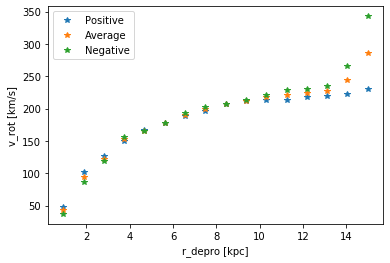

In [15]:
plt.plot(r_dep,max_vel,'*',label = 'Positive')
plt.plot(r_dep,ave_vel,'*',label = 'Average')
plt.plot(r_dep,np.abs(min_vel),'*',label = 'Negative')
plt.ylabel('v_rot [km/s]')
plt.xlabel('r_depro [kpc]')
plt.legend()
plt.show

In [16]:
vel_t_7443 = np.sqrt(velocity(r_dep)**2 + v_d(r_dep)**2 + v_h_iso(r_dep)**2)

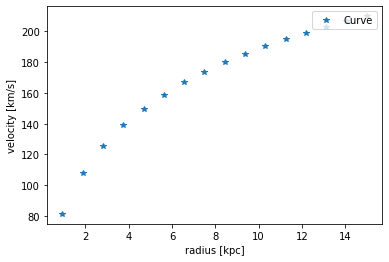

In [17]:
# Using Milky Way Paramters
plt.plot(r_dep,vel_t_7443*(3.08*10**13),'*',label = 'Curve')
plt.ylabel('velocity [km/s]')
plt.xlabel('radius [kpc]')
plt.legend(loc='upper right')
plt.show()

In [42]:
# bulge 
# a = sigma_be

gamma = 3.3308
kappa = gamma*ln(10)

def sigma_b(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M_sol/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: surface density of the bulge (g/pc^2)
    '''
    return a*(10**3)*(1.988*10**3)*np.exp(-1*kappa*((x/(b*10**3))**0.25-1))
                           
# derivative of sigma with respect to r
def dsdx(x,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: derivative of sigma (g/pc^3)
    '''
    return sigma_b(x,a,b)*(-0.25*kappa)*((b*10**3)**-0.25)*(x**-0.75)

# integrand for getting denisty
def density_integrand(x,r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: integrand for volume density of the bulge (g/pc^3)
    '''
    return -(1/np.pi)*dsdx(x,a,b)/np.sqrt(x**2-r**2)

def mass_integrand(r,a,b):
    '''
    parameters:
    x (projected radius): The projected rdius  (pc)   
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: volume density of the bulge
    '''
    vol_den, vol_den_err = inte.quad(density_integrand, r, np.inf, args=(r,a,b))
    return 4*np.pi*vol_den*r**2
    
# getting a velocity
def vel_b(r,a,b):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    
    return: rotational velocity of the bulge (pc/s)
    '''
    bulge_mass = np.zeros(len(r))
    vel = np.zeros(len(r))
    for i,val in enumerate(r):
        bulge_mass[i],err = inte.quad(mass_integrand, 0, val, args=(a,b))
        vel[i] = np.sqrt(bulge_mass[i]*G/val)
    return vel

In [43]:
# disk
# c = sigma_dc
# d = r_d

def integrand_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: integrand for volume density of the disk
    '''
    return 2*np.pi*c*(10 ** 2)*(1.988E33)*np.exp(-1*(r/(d*10**3)))*r

def mass_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: mass of the disk (g)
    '''
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_d, 0, val, args=(c,d))
        res[i] = y
    return res

def vel_d(r,c,d):
    '''
    parameters:  
    r (radius): The a distance from the centre (pc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    
    return: rotational velocity of the disk (pc/s)
    '''
    return np.sqrt(mass_d(r,c,d)*G/r)

In [44]:
# halo (isothermal)
# e = rho_0_iso
# f = h

def rho_iso(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: volume density of the isothermal halo (g/pc^3)
    '''
    return e*(1.988E33)/(1 + (r/(f*10**3))**2)

def integrand_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: integrand for getting the mass of the isothermal halo 
    '''
    return 4*np.pi*(rho_iso(r,e,f))*r**2

def mass_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: mass of the isothermal halo (g)
    '''
    res = np.zeros_like(r)
    for i, val in enumerate(r):
        y, err = inte.quad(integrand_h, 0, val, args=(e,f))
        res[i] = y
    return res

def vel_h(r,e,f):
    '''
    parameters:
    r (radius): The a distance from the centre (pc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    
    return: rotational velocity of the isothermal halo (pc/s)
    '''
    return np.sqrt(mass_h(r,e,f)*G/r)

In [45]:
def v_co(r,a,b,c,d,e,f):
    '''
    r (radius): The a distance from the centre (pc)
    a (central density): The central density of the bulge (M/pc^2)
    b (central radius): The central radius of the bulge (kpc)
    c (central surface density): The central surface density of the disk (M/pc^2)
    d (radius radius): The central radius of the disk (kpc)
    e (central density): The central density of the isothermal halo (M/pc^2)
    f (scale radius): The scale radius of the dark matter halo (kpc)
    '''
    return np.sqrt((vel_b(r,a,b)**2) + (vel_d(r,c,d)**2) + (vel_h(r,e,f)**2))

Text(0.5, 0, 'r_depro [pc]')

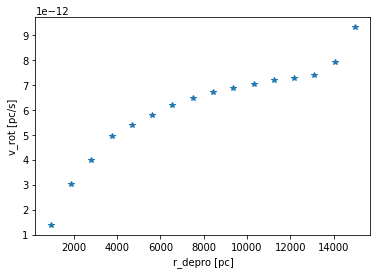

In [46]:
plt.plot(r_dep_list, ave_vel_list,'*')
plt.ylabel('v_rot [pc/s]')
plt.xlabel('r_depro [pc]')

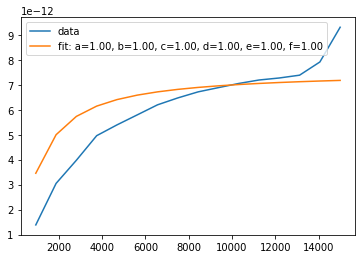

In [47]:
popt, pcov = curve_fit(v_co, r_dep_list, ave_vel_list, bounds=(0,np.inf))
plt.plot(r_dep_list, ave_vel_list,label='data')
plt.plot(r_dep_list, v_co(r_dep_list, *popt), label='fit: a=%.2f, b=%.2f, c=%.2f, d=%.2f, e=%.2f, f=%.2f' % tuple(popt))
plt.legend()
plt.show()

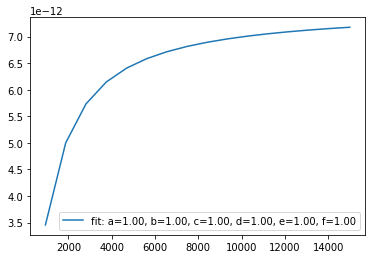

In [48]:
plt.plot(r_dep_list, v_co(r_dep_list, *popt), label='fit: a=%.2f, b=%.2f, c=%.2f, d=%.2f, e=%.2f, f=%.2f' % tuple(popt))
plt.legend()
plt.show()

In [49]:
# Messing around with different values
test_params = (3.2,0.5,8.44,3.5,0.74,10)

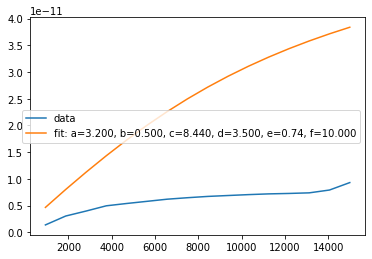

In [50]:
plt.plot(r_dep_list, ave_vel_list,label='data')
plt.plot(r_dep_list, v_co(r_dep_list, *test_params), label='fit: a=%.3f, b=%.3f, c=%.3f, d=%.3f, e=%.2f, f=%.3f' % tuple(test_params))
plt.legend()
plt.show()

/Users/richardzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


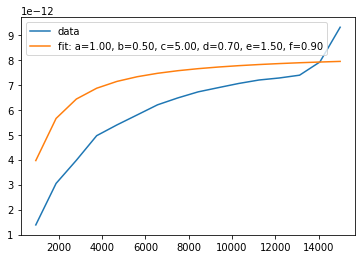

In [31]:
popt, pcov = curve_fit(v_co, r_dep_list, ave_vel_list, p0 = test_params, bounds=(0,[5,5,5,5,5,5]))
plt.plot(r_dep_list, ave_vel_list,label='data')
plt.plot(r_dep_list, v_co(r_dep_list, *popt), label='fit: a=%.2f, b=%.2f, c=%.2f, d=%.2f, e=%.2f, f=%.2f' % tuple(popt))
plt.legend()
plt.show()